In [1]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# O modelo sendo carregado é KeyedVectors. Cada termo é corresponde a uma chave referente ao vetor.
# O arquivo abaixo não está disponível no GitHub, pois possui *2.4GB*. 
# Pode ser obtido diretamente em http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s300.zip
kv_from_txt = KeyedVectors.load_word2vec_format('C:\\Users\\diogo\\Documents\\tcc\\cbow_s300.txt', binary=False)
print('Tamanho do vocabulário: ' + str(len(kv_from_txt.vocab)))

Tamanho do vocabulário: 929606


In [2]:
import pandas as pd

# Licitações realizadas no RS em 2019, segundo dados do TCE. 
# Arquivo disponível no repositório e em http://dados.tce.rs.gov.br/dados/licitacon/licitacao/ano/2019.csv.zip
df_licitacoes= pd.read_csv('licitacao.csv')
df_licitacoes.head()

C:\Users\diogo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (22,52,54) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CD_ORGAO,NM_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_COMISSAO,ANO_COMISSAO,TP_COMISSAO,NR_PROCESSO,ANO_PROCESSO,...,TP_DOCUMENTO_VENCEDOR,NR_DOCUMENTO_VENCEDOR,VL_HOMOLOGADO,BL_GERA_DESPESA,DS_OBSERVACAO,PC_TX_ESTIMADA,PC_TX_HOMOLOGADA,BL_COMPARTILHADA,BL_COVID19,LINK_LICITACON_CIDADAO
0,42900,PM DE CACEQUI,3007.0,2019,PRD,NaN,NaN,NaN,3007,2019.0,...,NaN,NaN,NaN,S,NaN,NaN,NaN,N,N,http://www1.tce.rs.gov.br/aplicprod/f?p=50500:...
1,42900,PM DE CACEQUI,3021.0,2019,PRD,NaN,NaN,NaN,3021,2019.0,...,NaN,NaN,NaN,S,NaN,NaN,NaN,N,N,http://www1.tce.rs.gov.br/aplicprod/f?p=50500:...
2,200,TRIBUNAL DE CONTAS DO ESTADO DO RS,4.0,2019,PRI,NaN,NaN,NaN,4860200186,2019.0,...,NaN,NaN,NaN,S,"No cálculo do valor contratado, foi levado em ...",NaN,NaN,N,N,http://www1.tce.rs.gov.br/aplicprod/f?p=50500:...
3,200,TRIBUNAL DE CONTAS DO ESTADO DO RS,10.0,2019,PRI,NaN,NaN,NaN,0015090200193,2019.0,...,NaN,NaN,NaN,S,NaN,NaN,NaN,N,N,http://www1.tce.rs.gov.br/aplicprod/f?p=50500:...
4,44401,CM DE CANGUÇU,1.0,2019,PRP,111.0,2018.0,G,6,2019.0,...,NaN,NaN,0.0,S,NaN,NaN,NaN,N,N,http://www1.tce.rs.gov.br/aplicprod/f?p=50500:...


In [3]:
"""
  Cria uma nova coluna no DataFrame removendo para adicionar a descrição da licitação após as seguinte transformações
  - Remoção de stop-words
  - Remoção do nome do órgão
  - Remoção de palavras não constantes no vocabulário word2vec
  - Se não sobrou palavra que descreva a licitação, esta é removida do dataset utilizado nas etapas posteriores
  - df_transform é o Pandas DataFrame resultante e utilizado nas etapas subsequentes
  
"""
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


tokenizer = CountVectorizer().build_tokenizer()
stop_words_portugues = stopwords.words('portuguese')
licitacoes_nao_reconhecidas = []

def remove_stop_words(tokens):
    tokens_result = list(tokens)
    tokens_result = [t for t in tokens_result if t not in stop_words_portugues]
    return tokens_result
    
def remove_nome_orgao(sample_licitacao, tokens):
    tokens_result = list(tokens)
    tokens_nome_orgao = tokenizer(sample_licitacao['NM_ORGAO'].lower())
    tokens_result = [t for t in tokens_result if t not in tokens_nome_orgao]
    return tokens_result

def remove_palavras_fora_vocabulario(tokens):
    tokens_result = list(tokens)
    tokens_remover = []
    for t in tokens:
        try:
            vetor_palavra = kv_from_txt.get_vector(t)
        except KeyError:
            tokens_remover.append(t)
    tokens_result = [t for t in tokens if t not in tokens_remover]        
    return tokens_result

def prepara_descricao_licitacao(sample_licitacao):
    licitacao_lower = sample_licitacao['DS_OBJETO'].lower()
    tokens = tokenizer(licitacao_lower)
    tokens = remove_stop_words(tokens)
    tokens = remove_nome_orgao(sample_licitacao, tokens)
    tokens = remove_palavras_fora_vocabulario(tokens)
    
    return ' '.join(tokens)

df_transform = pd.DataFrame(df_licitacoes, columns=['NM_ORGAO', 'VL_LICITACAO', 'DS_OBJETO', 'DS_OBJETO_LIMPO'])
df_transform['DS_OBJETO_LIMPO'] = df_transform.apply(lambda linha: prepara_descricao_licitacao(linha), axis=1)

# Após o tratamento de dados alguns poucos (samples) são removidos
df_removidas = pd.DataFrame(df_transform.loc[df_transform['DS_OBJETO_LIMPO'] == ''],  columns=['DS_OBJETO'])
df_transform.drop(df_transform[df_transform['DS_OBJETO_LIMPO'] == ''].index, inplace=True)
df_transform.reset_index(inplace = True, drop = True)
pd.options.display.max_colwidth = 200
df_transform.head(10)


,NM_ORGAO,VL_LICITACAO,DS_OBJETO,DS_OBJETO_LIMPO
0,PM DE CACEQUI,5.00,CONTRATACAO DE LEILOEIRO OFICIAL PARA PROCEDER COM O LEILAO DOS BENS MUNICIPAIS INSERVIVEIS,leiloeiro oficial proceder bens municipais
1,PM DE CACEQUI,3600.00,CONTRATACAO DE DJ PARA O CARNAVAL DE RUA DE 2019,dj carnaval rua
2,TRIBUNAL DE CONTAS DO ESTADO DO RS,201236.87,"Fornecimento de energia para o Serviço Regional de Auditoria de Pelotas, para o prédio Anexo e para o SPM",fornecimento energia serviço regional auditoria pelotas prédio anexo spm
3,TRIBUNAL DE CONTAS DO ESTADO DO RS,3500.00,"Renovação de 5 assinaturas do Jornal do Comércio (Ministério Público de Contas, Consultoria Técnica, Assessoria de Comunicação Social e 2 gabinetes de conselheiro).",renovação assinaturas jornal comércio ministério público consultoria técnica assessoria comunicação social gabinetes conselheiro
4,CM DE CANGUÇU,28980.00,Aquisição de 6000 Litros de gasolina aditivada,aquisição litros gasolina aditivada
5,PM DE CIRÍACO,0.00,PRESTAÇÃO DE SERVIÇOS DE AULAS DE DANÇAS FOLCLÓRICAS GAUCHESCAS,prestação serviços aulas danças folclóricas gauchescas
6,FUND. DE ASSIST. SOCIAL - CAXIAS DO SUL,5231.32,"Contratação de companhia seguradora para a prestação de serviços de cobertura, por meio de seguro, de veículo da frota da FAS.",contratação companhia seguradora prestação serviços cobertura meio seguro veículo frota fas
7,CM DE GRAMADO,16700.00,"Contratação de mão de obra especializada para realização dos serviços de manutenção e pintura nas escadas e corrimões da parte social interna e da estrutura metálica das garagens, no imóvel sede d...",contratação mão obra especializada realização serviços manutenção pintura escadas corrimões parte social interna estrutura metálica garagens imóvel sede câmara municipal
8,PM DE FAXINAL DO SOTURNO,10640.00,Contratação de empresa para a prestação de serviços de recapagem de pneus.,contratação empresa prestação serviços recapagem pneus
9,PM DE FORMIGUEIRO,3500.00,"Contratação de profissional capacitado na área ambiental, para realizar projeto de licenciamento ambiental do empreendimento público denominado oficina mecânica. Empreendimento instalado no parque...",contratação profissional capacitado área ambiental realizar projeto licenciamento ambiental empreendimento público denominado oficina mecânica empreendimento instalado parque máquinas prefeitura m...


In [4]:
# Lista de data samples removidos de acordo com critérios anteriormente descritos
df_removidas.head(20)

,DS_OBJETO
5813,A
5825,MANUTENCAO DA ROCADEIRA
8570,CONTRIBUICOES.
18672,AQUISICAO DE DIVISORIAS
21450,AQUISICAO DE VEICULOPE 027/2019PA 068/2019
29590,PARA A 22ª KARTOFFELFEST
31372,SONORIZACAO
31375,SONORIZACAO
41044,PAVIMENTACAO
49527,AutoPatrol


In [5]:
indice_amostras = range(0, 80000, 8000)
df_amostra_licitacoes = pd.DataFrame(df_transform.iloc[indice_amostras], columns=['DS_OBJETO', 'DS_OBJETO_LIMPO'])
df_amostra_licitacoes.head(10)

,DS_OBJETO,DS_OBJETO_LIMPO
0,CONTRATACAO DE LEILOEIRO OFICIAL PARA PROCEDER COM O LEILAO DOS BENS MUNICIPAIS INSERVIVEIS,leiloeiro oficial proceder bens municipais
8000,"Contratação de Empresa em regime de empreitada global, objetivando a execução de serviços de Drenagem, Pavimentação e Recapeamento Asfáltico de Vias Urbanas com concreto Betuminoso Usinado a Quente.",contratação empresa regime empreitada global objetivando execução serviços drenagem pavimentação recapeamento asfáltico vias urbanas concreto betuminoso usinado quente
16000,"PAGAMENTO DE TAXA CREA - ART PARA FINS DE CONSTITUIÇÃO DE COMISSÃO PARA AVALIAÇÃO DE IMÓVEL, PARA FINS DE OUTORGA ONEROSA DO DIREITO DE CONSTRUIR, CONFORME ARTIGOS 157 A 164 DA LEI Nº 3940/2018, D...",pagamento taxa crea art fins constituição comissão avaliação imóvel fins outorga onerosa direito construir conforme artigos lei nº novembro plano diretor municipal avaliação imóvel propriedade ber...
24000,"AQUISIÇÃO DE UM VEICULO TIPO MICRO- ONIBUS ZERO KM PARA A SECRETARIA MUNICIPAL DE SAUDE, CONFORME PROPOSTA Nº97531.256000/1180-08/ MINISTERIO DA SAUDE.",aquisição veiculo tipo micro onibus zero km secretaria municipal saude conforme proposta ministerio saude
32000,"Registro de preços para aquisição de troféus e medalhas para premiação dos campeonatos municipais, à serem adquiridos de forma fracionada pelo período de um ano.",registro preços aquisição troféus medalhas premiação campeonatos municipais serem adquiridos forma fracionada período ano
40000,Registro de preços para aquisição de brita,registro preços aquisição brita
48000,"Contratação de empresa para prestação de serviços de restauração, reparo e pintura da praça municipal.",contratação empresa prestação serviços restauração reparo pintura praça municipal
56000,CONTRATAÇÃO DE EMPRESA PARA FORNECIMENTO DE MÃO-DE-OBRA PARA EXECUÇÃO DE SERVIÇOS DE CONSTRUÇÃO DE PONTE DE MADEIRA.,contratação empresa fornecimento mão obra execução serviços construção ponte madeira
64000,SERVIÇO CONTRATAÇÃO DE INSTITUIÇÃO FINANCEIRA PARA PRESTAÇÃO SERVIÇODE GERENCIAMENTO E PROCESSAMENTO DE FOLHA DE PAGAMENTO DOS SERVIDORES PÚBLICOS MUNICIPAIS,serviço contratação instituição financeira prestação serviçode gerenciamento processamento folha pagamento servidores públicos municipais
72000,"Contratação de empresa especializada para a prestação de serviços continuados de manutenção predial preventiva e corretiva dos sistemas hidráulicos, dos equipamentos e das instalações, que compree...",contratação empresa especializada prestação serviços continuados manutenção predial preventiva corretiva sistemas hidráulicos equipamentos instalações compreenderá fornecimento postos serviço todo...


In [6]:
# 1. Executa o algoritmo Tf-Idf, atribui o resultado a matriz_tfidf.
# 

# 2. Criando uma matriz contendo apenas as palavras utilizadas no corpus (tfidf_vectorizer.get_feature_names()). 
# A criação desta matriz facilita e dá um grande ganho de performance no processo de vetorização. 
# Ao final imprime o formato da matriz. Deve ter o número de palavras x 300 - correspondente ao word embedding de cada um
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
matriz_tfidf = tfidf_vectorizer.fit_transform(df_transform['DS_OBJETO_LIMPO'])

matriz_vv_vocabulario_licitacoes = np.zeros((0, 300), 'float64')
for palavra in tfidf_vectorizer.get_feature_names():
    vetor_palavra = kv_from_txt.get_vector(palavra)
    matriz_vv_vocabulario_licitacoes = np.append(matriz_vv_vocabulario_licitacoes, np.array([vetor_palavra]), axis=0)

print('matriz_tfidf.shape: ' + str(matriz_tfidf.shape))
print('matriz_vv_vocabulario_licitacoes.shape: ' + str(matriz_vv_vocabulario_licitacoes.shape))


matriz_tfidf.shape: (80202, 31835)
matriz_vv_vocabulario_licitacoes.shape: (31835, 300)


In [7]:
# Gera uma matriz com dimensão data samples (numero de licitações) x 300 (conforme word embedding utilizado).
# Cada linha da matriz corresponde à soma do vetor de cada palavra multiplicado pelo respectivo Tf-Idf. 
# Assim, palavras como menor Tf-Idf, muito frequentes contribuem menos.
# O resultado é uma média ponderada pelo Tf-Idf

# Estudos sobre a técnica podem ser encontrados em https://www.oxinabox.net/publications/White2015SentVecMeaning.pdf e
# https://www.aclweb.org/anthology/P16-1089.pdf.

print('matriz_tfidf.shape: ' + str(matriz_tfidf.shape))
print('matriz_vv_vocabulario_licitacoes.shape> ' + str(matriz_vv_vocabulario_licitacoes.shape))

matriz_licitacoes = matriz_tfidf * matriz_vv_vocabulario_licitacoes
print('matriz_licitacoes.shape: ' + str(matriz_licitacoes.shape))

matriz_tfidf.shape: (80202, 31835)
matriz_vv_vocabulario_licitacoes.shape> (31835, 300)
matriz_licitacoes.shape: (80202, 300)


In [8]:
# Similaridade de cosseno entre os vetores que representam cada sentença para avaliar as n mais similares licitações. 
# Toma-se o índice de um sample na variável ind_licitacao_a_comparar 
# A saída é a lista de licitações mais similares e o valor do cosseno entre estas e a licitação tomada como base
# O cosseno é utilizado para ordenação
# A própria licitação base também aparece como mais similar, devendo possuir cosseno 1.

from sklearn.metrics.pairwise import cosine_similarity

ind_licitacao_a_comparar = 900
n = 20
v1 = matriz_licitacoes[ind_licitacao_a_comparar]

# Calcula cosseno entre a licitação a comparar (vetor v1) e todas as demais
matriz_cosseno = cosine_similarity([v1], matriz_licitacoes)

# argsort funciona como se ordenasse o vetor (em ordem crescente), mas ao invés de retornar o vetor ordenado retorna o índice dos elementos ordenados. Como queremos os maiores primeiro, multiplica-se o vetor dos cossenos por -1.
vetor_indice_maiores_cossenos = np.argsort(matriz_cosseno * -1)[0]


print('Sentenca base: ' + df_transform['DS_OBJETO'][ind_licitacao_a_comparar] + '\n')

array_cossenos = np.array([matriz_cosseno[0][i] for i in vetor_indice_maiores_cossenos[:n]])
pd.options.display.max_colwidth = 300
df_mais_similares = pd.DataFrame(df_transform.loc[vetor_indice_maiores_cossenos[:n]]['DS_OBJETO'], columns=['DS_OBJETO'])
df_mais_similares['COSSENO'] = array_cossenos
df_mais_similares.head(20)

Sentenca base: SERVIÇO TÉCNICO DE REESTRUTURAÇÃO DO WEBSITE DO BRDE NA INTERNET.



,DS_OBJETO,COSSENO
900,SERVIÇO TÉCNICO DE REESTRUTURAÇÃO DO WEBSITE DO BRDE NA INTERNET.,1.000000
76921,"Prestação de serviço de desenvolvimento e manutenção, do Portal de Internet (website) do MUNICÍPIO",0.806963
34658,Serviços de implantação e manutenção de website,0.767913
29579,"CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA O DESENVOLVIMENTO, MANUTENÇÃO E SUPORTE TÉCNICO DE WEBSITE DO MUNICÍPIO DE COTIPORÃ/RS.",0.760008
29185,Contratação de empresa para a realização de serviço de manutenção de atualização do website do município de Relvado/RS.,0.746047
78027,"Criação de um site institucional para o SAE com desenvolvimento do site, manutenção e suporte técnico do site, marketing de conteúdo, gestão de redes sociais e criação do logo.",0.725953
25533,CONTRATAÇÃO DE EMPRESA PARA PRESTAÇÃO DE SERVIÇO DE CRIAÇÃO DESENVOLVIMENTO E REFORMULAÇÃO DO SITE QUE CONSISTE NA ÁREA ADMINISTRATIVA PARA GERENCIAMENTO DO CONTEÚDO QUE POSSIBILITARA ALTERAÇÕES DO CONTEÚDO DO SITE,0.718380
28431,"CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA ACOMPANHAMENTO, SUPORTE E MANUTENÇÃO DE WEBSITE",0.716598
39396,"CONTRATAÇÃO DE PRESTAÇÃO DE SERVIÇO DE MANUTENÇÃO, SEGURANÇA E HOSPEDAGEM DO PORTAL DA INTERNET, DO SITE DO MUNICIPIO",0.716552
46577,"Contratação de empresa para prestação de serviços de hospedagem e manutenção do website e e-mails do domínio da Prefeitura Municipal de Ponte Preta, bem como serviço de assessória, envolvendo o acompanhamento da divulgação do conteúdo.",0.713082


1. CONTRATAÇÃO DE EMPRESA PARA FORNCECIMENTO DE EQUIPAMENTO PARA SONORIZAÇÃO DO DESFILE FARROUPILHA NO DIA 20/09/2019
2. Renovação de subscrição de licenças e prestação de serviços de suporte técnico especializado on-site para a solução de colaboração Zimbra Collaboration Network Edition.
3. PARA O MUNICÍPIO DE SANTA MARIA DO HERVAL
4. Pregão Presencial Registro de Preços para fornecimento de gêneros alimentícios para as Secretarias.
5. Aquisição de peças e serviços de mão de obra para recuperar o sistema hidraulico  e motor de tração do trator de esteiras TRATOR DE ESTEIRA KOMATSU D51E com registro patrimonial n° 06/00091 da SECRETARIA DA AGRICULTURA  do municipio de ERVAL GRANDE - RS 
6. Mão de obra veículo Ducato, Diesel, ano 2009, Placa: IQD9214.
7. AQUISIÇÃO DE MEDICAMENTOS DE USO VETERINÁRIO CONFORME ANEXO I DO EDITAL.
8. PRESTAÇÃO DE SERVIÇOS DE ACESSO À INTERNET.
9. Aquisição de Peças e Serviços para Conserto da Kombi ISW 5432
10. Contratação de empresa para prestação de serviç

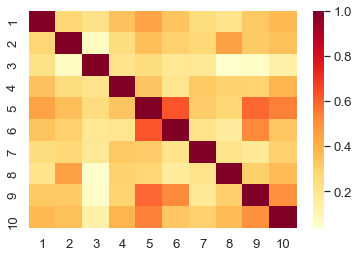

In [286]:
import seaborn as sns
import numpy as np
from random import randrange
from sklearn.metrics.pairwise import cosine_similarity as cosine

samples = matriz_licitacoes.shape[0]
numero_comparacoes = 10
texto = []

matriz_heat_map = np.zeros((0, 300), 'float64')
for i in range(numero_comparacoes):
    indice_licitacao = randrange(samples)
    vetor_licitacao = matriz_licitacoes[indice_licitacao]
    texto.append(df_transform['DS_OBJETO'][indice_licitacao])
    matriz_heat_map = np.append(matriz_heat_map, np.array([vetor_licitacao]), axis=0)

matriz_cosseno = cosine(matriz_heat_map)
for i in range(numero_comparacoes):
    print(str(i + 1) + '. ' + texto[i])

sns.set(font_scale=1.2)
grafico = sns.heatmap(matriz_cosseno[0:], xticklabels = range(1, numero_comparacoes + 1), 
                      yticklabels = range(1, numero_comparacoes + 1), cmap="YlOrRd")
    

In [9]:
# Criando uma matriz normalizada, onde a soma dos quadrados dos elementos é igual a 1. 
# Esta matriz será utilizada para clusterização, sendo todos os vetores do mesmo tamanho, e a clusterização tomando como base
# a distância, equivale a uma clusterização por cossenos
import numpy as np

length_matriz = np.sqrt((matriz_licitacoes**2).sum(axis=1))[:,None]
matriz_normalizada = matriz_licitacoes / (length_matriz)
print(matriz_normalizada.shape)

(80202, 300)


In [39]:
# ATENÇÃO: Este processamento é lento, podendo levar mais de 24 horas.
# O resultado será salvo no arquivo 'matriz_elbow.npy' (já disponibilizado junto a este Notebook)
# no intuito de não exigir a execução desta etapa a todo momento. 
# O algoritmo k-means será aplicado com um número de clusters variando de 10 a 400
# O objetivo desta etapa é determinar visualmente o número de clusters, utilizando o método 'Elbow', ou método do cotovelo
# em que o número ideal de clusters é baseado levando-se em consideração o número de clusters e a distância média dos elementos 
# e seu centróide.

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime

k_means_range = range(10, 400)

inertias = []

print('Inicio - K-Means - Elbow method: {}'.format(datetime.now()))
for n in k_means_range:
    kmeans = KMeans(n_clusters=n)
    clusters = kmeans.fit_predict(matriz_normalizada)
    inertias.append(kmeans.inertia_)
print('Fim - K-Means - Elbow method: {}'.format(datetime.now()))

matriz_elbow = np.array([k_means_range,inertias])
print("Salvando matriz K-Means - Elbow. Shape {}".format(matriz_elbow.shape))
np.save('matriz_elbow.npy', matriz_elbow)

Inicio - K-Means - Elbow method: 2021-02-01 14:11:10.102207
Fim - K-Means - Elbow method: 2021-02-02 06:53:12.533731
Salvando matriz K-Means - Elbow. Shape (2, 290)


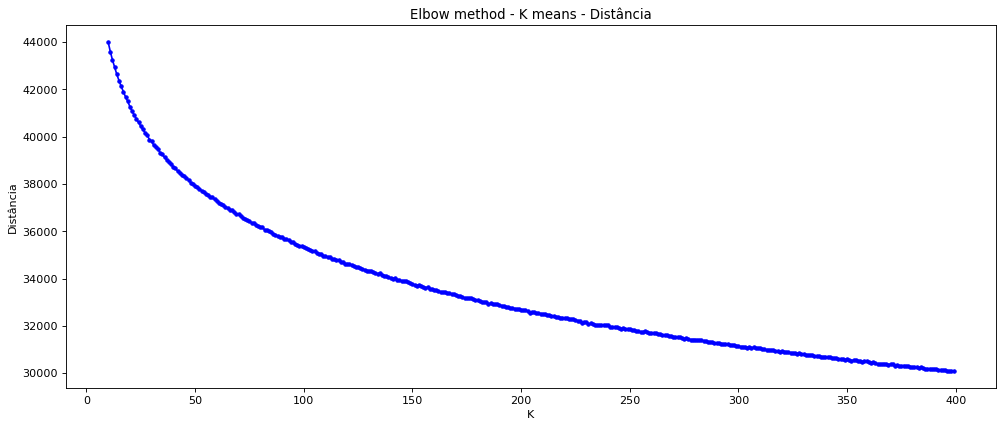

In [10]:
# Baseado no arquivo salvo na etapa anterior
import numpy as np
import matplotlib.pyplot as plt

matriz_elbow = np.load('matriz_elbow.npy')

plt.figure(figsize=(15, 6), dpi=80)
plt.plot(matriz_elbow[0,:], matriz_elbow[1,:], '-b.') 
plt.xlabel('K') 
plt.ylabel('Distância') 
plt.title('Elbow method - K means - Distância') 
plt.show() 

In [12]:
# Redução de dimensionalidade para visualização. 
# A dimensão da matriz a ser reduzida é de 80.202 (número de samples, após tratamento) x 300 (dimensão do word embeddings utilizado)

from sklearn.manifold import TSNE
from datetime import datetime

tsne = TSNE(n_components=2)
print('Inicio - TSNE: {}'.format(datetime.now()))
matriz_tsne = tsne.fit_transform(matriz_normalizada)
print("Salvando matriz TSNE. Shape {}".format(matriz_tsne.shape))
np.save('matriz_tsne.npy', matriz_tsne)
print('Fim - TSNE: {}'.format(datetime.now()))

print(matriz_tsne.shape)

Inicio - TSNE: 2021-02-04 19:58:19.162132
Salvando matriz TSNE. Shape (80202, 2)
Fim - TSNE: 2021-02-04 21:48:02.634451
(80202, 2)


In [11]:
import numpy as np
matriz_tsne = np.load('matriz_tsne.npy')
print("matriz_tsne.shape {}".format(matriz_tsne.shape))

matriz_tsne.shape (80202, 2)


In [12]:
# Escolhido o número de clusters, após visualizar a curva acima
from sklearn.cluster import KMeans

k_means_numero_grupos = 100

kmeans = KMeans(n_clusters = k_means_numero_grupos)
clusters = kmeans.fit_predict(matriz_normalizada)

In [15]:
# A partir de uma licitação busca as demais do mesmo cluster
grupo_sentenca_exemplo = clusters[900]

indice_sentencas_mesmo_grupo = [index for index, cluster in enumerate(clusters) if cluster == grupo_sentenca_exemplo]
    
pd.options.display.max_colwidth = 300
df_grupo = pd.DataFrame(df_transform.loc[indice_sentencas_mesmo_grupo],  columns=['NM_ORGAO', 'VL_LICITACAO', 'DS_OBJETO'])
df_grupo.head(10)

,NM_ORGAO,VL_LICITACAO,DS_OBJETO
40,PM DE PAVERAMA,4360.00,Contratação de serviços de internet
45,CM DE ESTAÇÃO,1188.00,"Fornecimento de Comunicação Multimídia para uso privativo e exclusivo de acesso à internet, de forma ilimitada, com link de internet com velocidade de 10Mbps de download e 3Mbps de uploud, atendimento 24 horas, sem limite de conexão"
182,CM DE HERVEIRAS,1078.80,"Prestação de serviços de acesso a INTERNET, através da transmissão do sinal via rádio para a Secretaria da Câmara de Herveiras, através da disponibilização de acesso a INTERNET Plano Pro Plus 4 Mb, residencial ilimitado, taxa de download até 4 Megabits/s, taxa de upload até 1 Megabit/s, garantia..."
297,PM DE PIRAPÓ,4000.00,"Aquisição de materiais e serviços de mão de obra para instalação de fibra óptica entre a sede administrativa e o parque de exposições e rodeios, para habilitar a comunicação a qual transmitirá sinal de internet e telefonia."
421,PM DE JAGUARÃO,2280.00,Serviço de telefonia n° 32616503. Secretaria Municipal da Fazenda
439,PM DE JAGUARÃO,900.00,Serviço de telefonia. SMA N° telefone: 3261-167-98.
440,PM DE JAGUARÃO,3499.92,Serviço de telefonia n° 32615275. CRAS Pindorama
441,PM DE JAGUARÃO,3000.00,Serviço de telefonia n° 32613041. CRAS Germano.
511,COMUSA - SERVIÇOS DE ÁGUA E ESGOTO DE NOVO HAMBURGO,15013.26,"Processo: 3-30/11/2018. Contratação de empresa para prestação de serviços de instalação, locação, manutenção e suporte de enlaces de dados em fibra ótica ou rádio digital nas velocidades de banda de 5 (cinco) Mbps simétricos com 99,5% de garantia mínima, visando a interligação de diversas unidad..."
538,PM DE CAPÃO DO LEÃO,6300.00,contratação de empresa para monitoramento veicular via internet para seis veiculos novos recentemente adquiridos pela SMS.


In [322]:
# É o mesmo caso anterior, apenas uma outra licitação como exemplo
grupo_sentenca_exemplo = clusters[1]

indice_sentencas_mesmo_grupo = [index for index, cluster in enumerate(clusters) if cluster == grupo_sentenca_exemplo]
    
pd.options.display.max_colwidth = 300
df_grupo = pd.DataFrame(df_transform.loc[indice_sentencas_mesmo_grupo],  columns=['NM_ORGAO', 'VL_LICITACAO', 'DS_OBJETO'])
df_grupo.head(10)

,NM_ORGAO,VL_LICITACAO,DS_OBJETO
1,PM DE CACEQUI,3600.0,CONTRATACAO DE DJ PARA O CARNAVAL DE RUA DE 2019
145,FUND. CASA DAS ARTES DE BENTO GONÇALVES,350.0,Contratação de artista profissional para o evento Una Bella Serata.
218,PM DE PINHAL GRANDE,2500.0,"Contratação de empresa para Show Musical com “Nando Rodrigues e Banda” no dia 17 de Março de 2019, durante Programação da Semana do Município."
243,PM DE MARAU,3000.0,"CONTRATAÇÃO DE APRESENTAÇÃO ARTÍSTICA PARA EVENTO ""PROJETO VERÃO MAIS CULTURA"", NO DIA 17/03/2019 NA EVENIDA JÚLIO BORELLA DAS 18:00 ÀS 20:00. FUNDAMENTO LEGAL, ART. 25 INCISO III DA LEI 8.666/93"
363,PM DE TRAMANDAÍ,4500.0,"CONTRATACAO DE ROGER ANDREI DE CASTRO VASCONCELOS PARA A REALIZACAO DE 01 (UMA) PALESTRA SHOW DONA LITERARA ¿ UM SHOW DE AULA, NO DIA 20 DE FEVEREIRO DE 2019 AS 15H45MIN NA SAT NO EVENTO DE ABERTURA DO ANO LETIVO DE 2019."
364,PM DE TRAMANDAÍ,2500.0,"CONTRATACAO DE 02 SHOWS COM ISADORA MATOS E BANDA, SENDO 01 NO DIA 27/01 AS 21H NA PRACA LEONEL PEREIRA E NO DIA 02/02 AS 21H NO CENTRINHO DE OASIS SUL NA PROGRAMACAO DOS SHOWS DE VERAO."
366,PM DE TRAMANDAÍ,6000.0,"CONTRATACAO DA EMPRESA THAIS SOARES AIRES - ME PARA SHOWS DE CARNAVAL COM A BANDA METRO NOS DIAS 02/03/2019 E 04/03/2019 EM OASIS DO SUL, PARA OS BAILES DE CARNAVAL NO PALCO DO CENTRINHO COM DURACAO APROXIMADAMENTE DE 4 HORAS."
532,PM DE IMBÉ,3000.0,"Contratação de empresa GINGA BRASIL LOGISTICA E EVENTOS LTDA-ME para a realização do show gospel de Juliano Rimador,no dia 16/02/2019, que será realizado no Parque de Rodeio de Imbé."
730,PM DE BOA VISTA DO INCRA,2500.0,"APRESENTAÇÃO DO GRUPO MUSICAL - BANDA MILENNIO, COM EQUIPAMENTOS, INSTRUMENTAL E REPERTÓRIO ECLÉTICO, NO DIA 09/03/2019 NO EVENTO ""BAILE DAS MULHERES""."
775,PM DE XANGRI-LÁ,13000.0,CONTRATAÇÃO DE ARTISTA


In [14]:
# É o mesmo caso anterior, apenas uma outra licitação como exemplo
grupo_sentenca_exemplo = clusters[8000]

indice_sentencas_mesmo_grupo = [index for index, cluster in enumerate(clusters) if cluster == grupo_sentenca_exemplo]
    
pd.options.display.max_colwidth = 300
df_grupo = pd.DataFrame(df_transform.loc[indice_sentencas_mesmo_grupo],  columns=['NM_ORGAO', 'VL_LICITACAO', 'DS_OBJETO'])
df_grupo.head(10)

,NM_ORGAO,VL_LICITACAO,DS_OBJETO
292,PM DE SANTO EXPEDITO DO SUL,90172.43,"Contratação de Empresa para execução, em regime de empreitada global, execução da obra de Pavimentação Asfáltica em Concreto Betuminoso Usinado a Quente (CBUQ) e Sinalização Viária da Rua 19 de Abril, no perímetro urbano do município de Santo Expedito do Sul , o qual totaliza uma área a ser pavi..."
586,PM DE MONTENEGRO,1419815.51,"Contratação de empresa para a execução das obras de terraplanagem, pavimentação asfáltica em concreto betuminoso usinado á quente - CBUQ, drenagem pluvial e sinalização viária da estrada municipal denominada Estrada Geral Santos Reis - TRANSCITRUS, no subtrecho KM 1+644 a KM 2+937, sentido Norte..."
669,PM DE TRÊS ARROIOS,29990.00,"Contratação de empresa para prestação de serviços de projeto de pavimentação asfáltica, conforme termo de formalização de dispensa."
679,PM DE FORQUETINHA,0.00,"Edital de tomada de preços para a execução de serviços de pavimentação asfáltica de um trecho de 2.180,00 m², englobando as Ruas Phillip Nied e Phillip Muller, no centro da Cidade."
938,PM DE CANDELÁRIA,275977.69,CONTRATAÇÃO DE EMPRESA PARA EXECUÇÃO DA OBRA DE PAVIMENTAÇÃO EM BLOQUETOS DE CONCRETO DA RUA DOS SONHOS
967,PM DE PALMITINHO,48240.00,Contratação de empresa para prestação de serviços de mão de obra especializada para Recapeamento Asfáltico do município de Palmitinho/RS
986,PM DE TURUÇU,61450.81,Visa a Contratação de empresa especializada para O objeto desta tomada de preço é a contratação de empresa especializada para execução de calçadas e rampas de acessibilidade em trecho da Avenida Arthur Lange do Município de Turuçu-RS.
1000,PM DE FORMIGUEIRO,234655.00,"contratação de empresa prestadora de serviços para implantação de pavimentação, sarjeteamento, execução de bocas de lobo,rampas de acesso PNE, canalização pluvial, sinalização e pavimentação do passeio, na Avenida Gustavo Kath, no trecho compreendido entre o final do pavimento existente nessa av..."
1046,PM DE SÃO JOSÉ DO SUL,2531991.94,"Contratação de empresa em regime de empreitada global, incluindo-se material e mão de obra, para a execução dos serviços de pavimentação asfáltica, drenagem pluvial, sinalização viária, passeio e acessibilidade das Ruas Lindolfo Specht totalizando 4.340,69m², Irmãos Lerner totalizando 4.891,49m..."
1079,PM DE CANDELÁRIA,291281.80,CONTRATAÇÃO DE EMPRESA PARA EXECUÇÃO DA OBRA DE PAVIMENTAÇÃO EM BLOQUETOS DE CONCRETO DE RUAS DO BAIRRO EWALDO PRASS – ETAPA 3


In [16]:
# Gerando uma cor aleatória para cada cluster
import random
range_color = range(1, k_means_numero_grupos + 1)

r = lambda: random.randint(0,255)
palette = ['#%02X%02X%02X' % (r(),r(),r()) for color in range_color]
print(palette)

['#4C640B', '#03A264', '#067FCC', '#278D0F', '#EBA90D', '#1BE790', '#2A6E3B', '#4F3D79', '#1C5D35', '#3473F0', '#9EC4C7', '#CA9AF3', '#9334E3', '#66C21A', '#E1E123', '#385876', '#E170E7', '#7C0251', '#C1AC38', '#239559', '#38B6C3', '#ECA753', '#CDB666', '#258405', '#798608', '#83AC03', '#4ED8E9', '#7834D3', '#13BD03', '#D268CF', '#9BECB6', '#9CAD42', '#E80B57', '#F0E740', '#58A475', '#E45BDF', '#B4E6AC', '#65FCFA', '#90B495', '#FB3EFE', '#2BAC29', '#9F8271', '#882258', '#89754B', '#9A484D', '#E3081A', '#840340', '#A87181', '#941B68', '#A34A43', '#5691F6', '#4909C2', '#2C5CC3', '#634F0B', '#491BC4', '#3AFE3C', '#9698C5', '#4A48F1', '#AB1DA0', '#982C82', '#27B3B7', '#AF132C', '#C88AC3', '#6DF11D', '#BA350D', '#4A0830', '#7B4A66', '#192B36', '#B46962', '#7B38CE', '#7E5F42', '#BC602A', '#720E4B', '#C683EF', '#EE80B8', '#1C2947', '#C5798E', '#598906', '#84EDD0', '#F62542', '#EAB15E', '#C65249', '#D74D5C', '#E96930', '#E51DB0', '#60708C', '#42FD46', '#5E1618', '#74007C', '#A8B6C2', '#7D276E'

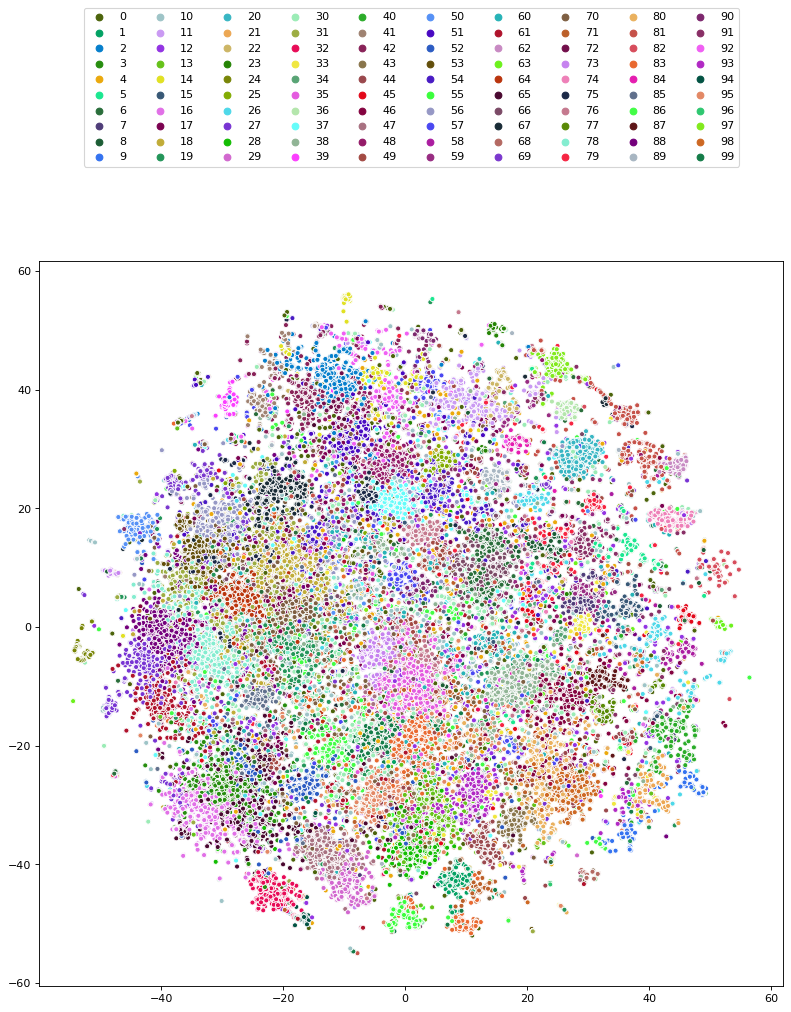

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12), dpi=80)
sns.scatterplot(x=matriz_tsne[:, 0], y=matriz_tsne[:, 1], hue=clusters, palette=palette, s=20)
plt.legend(bbox_to_anchor=(0.5, 1.35), borderaxespad=0, loc='upper center', ncol=10)